# Introduction

The purpose of this report is to perform RNAseq analysis using test data available in the nf-core rnaseq pipeline. The report was written using the Python and R languages.

# Quality control of the data

## Quality of raw data

The test data used have good quality, as can be seen in the example per_base_quality graphs for each sample.

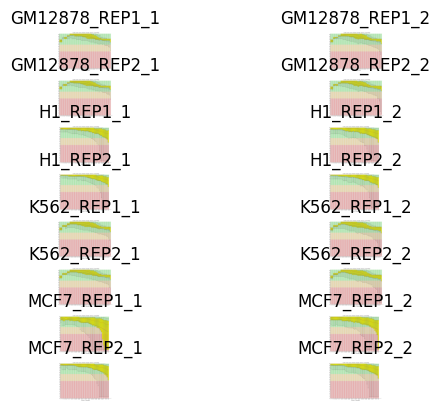

In [1]:
import os

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio

pio.renderers.default = (
    "iframe"  # or 'colab' or 'iframe' or 'iframe_connected' or 'sphinx_gallery'
)
import numpy as np
import pandas as pd
import PIL

sample_names = np.array(
    [
        "GM12878_REP1_1",
        "GM12878_REP1_2",
        "GM12878_REP2_1",
        "GM12878_REP2_2",
        "H1_REP1_1",
        "H1_REP1_2",
        "H1_REP2_1",
        "H1_REP2_2",
        "K562_REP1_1",
        "K562_REP1_2",
        "K562_REP2_1",
        "K562_REP2_2",
        "MCF7_REP1_1",
        "MCF7_REP1_2",
        "MCF7_REP2_1",
        "MCF7_REP2_2"
        
    ]
)

path = "/mnt/pool/playground/smigas/test-full/"
path_qc = path + "fastqc/"

for num, x in enumerate(sample_names):
    path_sample = path_qc + x
    img = PIL.Image.open(path_sample + "_fastqc/Images/per_base_quality.png")
    plt.subplot(8, 2, num + 1)
    plt.title(x.split(".")[0])
    plt.axis("off")
    plt.rcParams["figure.figsize"] = [13, 12]
    plt.imshow(img)

## Total sample counts

In [2]:
raw_counts = pd.read_csv(path + "salmon/salmon.merged.gene_counts.tsv", sep="\t")
raw_counts = raw_counts.drop(labels="gene_id", axis=1)
raw_counts = raw_counts.set_index("gene_name")
gene_list = raw_counts.index
raw_counts

,GM12878_REP1,GM12878_REP2,H1_REP1,H1_REP2,K562_REP1,K562_REP2,MCF7_REP1,MCF7_REP2
gene_name,,,,,,,,
TSPAN6,8.000,0.000,8591.778,4593.954,3.000,2.000,6736.203,4243.111
TNMD,0.000,0.000,71.000,35.000,0.000,0.000,3.000,0.000
DPM1,4301.000,3755.000,2015.893,867.517,6695.001,9275.000,11453.746,11043.872
SCYL3,2083.845,1690.051,680.154,469.026,1040.584,1531.396,2280.986,2335.833
C1orf112,2016.010,1746.026,3981.890,1951.694,3122.169,3222.999,4750.223,3933.307
...,...,...,...,...,...,...,...,...
RP4-621B10.8,0.000,0.000,0.000,3.000,0.000,0.000,2.000,0.000
RP11-114I8.4,37.000,69.000,18.000,11.000,4.000,10.000,104.000,117.000
RP11-180C16.1,3.000,0.000,148.000,68.000,0.000,4.000,18.000,16.009


In [4]:
# library size
raw_counts_sum_sample = pd.DataFrame(raw_counts.sum(), columns=["lib_size"])
raw_counts_sum_sample

,lib_size
GM12878_REP1,6.960645e+07
GM12878_REP2,6.906134e+07
H1_REP1,9.965728e+07
H1_REP2,8.175698e+07
K562_REP1,6.510871e+07
K562_REP2,8.057138e+07
MCF7_REP1,9.303433e+07
MCF7_REP2,9.649578e+07


In [ ]:
# matplotlib
plt.figure(figsize=(6, 6))
plt.xlabel("Total count")
plt.ylabel("Number of samples")
plt.title("Total sample counts for samples")
plt.hist(raw_counts_sum_sample)

In [ ]:
# plotly
fig = px.histogram(
    raw_counts_sum_sample,
    x="lib_size",
    width=800,
    height=400,
    labels={"lib_size": "Total count"},
)
fig.update_layout(title="Total sample counts for samples")
fig.show()

## Heatmap

In [ ]:
sample_dist = pd.read_csv(
    path + "star_salmon/deseq2_qc/deseq2.sample.dists.txt", sep="\t"
)
sample_dist = sample_dist.set_index("sample")
sample_dist
fig = px.imshow(
    sample_dist.values,
    labels=dict(x="Samples", y="Samples"),
    x=sample_dist.columns,
    y=sample_dist.columns,
)
fig.show()

## PCA

In [ ]:
pca_vals = pd.read_csv(path + "star_salmon/deseq2_qc/deseq2.pca.vals.txt", sep="\t")
pca_vals["group"] = ["female","female","female","female","female","female","male","male"]
pca_vals
fig = px.scatter(pca_vals, x="PC1: 43% variance", y="PC2: 27% variance", color="group")
fig.update_traces(marker=dict(size=20), selector=dict(mode="markers"))
fig.show()

## Convert raw counts to cpm

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R -i path
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("edgeR")
library(edgeR)
library(dplyr)

data = paste0(path,"/salmon/salmon.merged.gene_counts.tsv")

counts <- read.csv(data,sep="\t")
rownames(counts) <- counts$gene_id
counts <- counts %>% select(!c(gene_name,gene_id))

count_cpm = cpm(counts)
count_cpm
# write.table(count_cpm,paste0(path,"/salmon/salmon.merged.gene_counts.cpm.tsv"))


## Filtering 

Remove genes with low counts

In [ ]:
# Filtering
cpm = pd.read_csv(path + "salmon/salmon.merged.gene_counts.tsv", sep="\t")
min_group_size = 2
L = min(raw_counts_sum_sample["lib_size"])  # the minimum library size in millions
min_cpm = 10 / L
min_cpm
raw_counts = raw_counts.reset_index()

filter_condition = (cpm.drop(labels="gene_name", axis=1) > min_cpm).sum(
    axis=1
) >= min_group_size
counts_filtered = raw_counts[filter_condition]

In [ ]:
from plotly.figure_factory import create_distplot

cpm_log = pd.read_csv(path + "salmon/salmon.merged.gene_counts.cpm_log.tsv", sep="\t")
cpm_log.head()
cpm_log.drop("gene_name", axis="columns", inplace=True)
cpm_log_values = cpm_log[:].values
cpm_log_values = cpm_log_values.reshape(5, 125)

cpm_log_filtered = cpm_log[filter_condition]
cpm_log_filtered

In [ ]:
figure = ff.create_distplot(cpm_log_values, cpm_log.columns, show_hist=False)
figure.update_layout(title="Raw data", xaxis_title="Log−cpm", yaxis_title="Density")
figure.show()

In [ ]:
cpm_log_filtered_values = cpm_log_filtered[:].values
cpm_log_filtered_values = cpm_log_filtered_values.reshape(5, 93)

figure = ff.create_distplot(
    cpm_log_filtered_values, cpm_log_filtered.columns, show_hist=False
)
figure.update_layout(
    title="Filtered data", xaxis_title="Log−cpm", yaxis_title="Density"
)
figure.show()